In [ ]:
pip install soundfile

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
from scipy.signal import firwin, lfilter
from IPython.display import Audio

In [17]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [20]:
CRY_FILE = os.path.join('data', 'Crying','1-22694-A.wav')
NOT_CRY_FILE = os.path.join('data','Silence','pcm_wav','silence.wav_0.wav')

In [21]:
wave = load_wav_16k_mono(CRY_FILE)
nwave = load_wav_16k_mono(NOT_CRY_FILE)

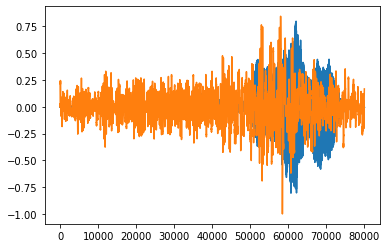

In [22]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
# 전처리 
# preprocess : STFT / adjust_values : Threshold-base Clipping method

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:80000]
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

def adjust_values(sample, label):
    # 0.5 이상의 값들을 0.5로, 0.1 이하의 값들을 0으로 조정
    sample = tf.where(sample >= 0.1, 1.0, sample)
    sample = tf.where(sample < 0.0, 0.0, sample)
    return sample, label

def resize_batch_spectrograms(spectrograms, labels):
    # spectrograms의 shape이 (batch_size, time, frequency, 1)인지 확인
    spectrograms = tf.ensure_shape(spectrograms, [None, None, None, 1])
    
    # spectrograms의 시간 축을 너비로 간주하고 리사이즈 (batch_size, 500, 161, 1)
    resized_spectrograms = tf.image.resize(spectrograms, [500, 161])
    return resized_spectrograms, labels

#normalization method 
def normalize(sample, label):
    # Z-score normalization
    mean = tf.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = (sample - mean) / std

    # Min-Max scaling to 0-1
    min_val = tf.reduce_min(sample)
    max_val = tf.reduce_max(sample)
    sample = (sample - min_val) / (max_val - min_val)

    return sample, label

In [23]:
POS = os.path.join('data','Crying')
NEG = os.path.join('data','male_speech')
# 파일을 데이터셋으로 읽어들이기
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')
# 경로가 올바른지 확인
print(f"Crying 경로: {POS}")
print(f"not_crying 경로: {NEG}")
# 파일 수 확인
pos_count = len(list(pos))
neg_count = len(list(neg))
print(f"Dataset에서 Crying 파일 수: {pos_count}")
print(f"Dataset에서 not_crying 파일 수: {neg_count}")

Crying 경로: data/Crying
not_crying 경로: data/male_speech
Dataset에서 Crying 파일 수: 490
Dataset에서 not_crying 파일 수: 408


In [24]:
# Label the data
pos_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(list(pos))))
neg_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(list(neg))))
# Combine files with labels
pos_data = tf.data.Dataset.zip((pos, pos_labels))
neg_data = tf.data.Dataset.zip((neg, neg_labels))

# Combine crying and not crying data
all_data = pos_data.concatenate(neg_data)
num_files = tf.data.experimental.cardinality(all_data).numpy()
print(f"Total number of files in all_data: {num_files}")

Total number of files in all_data: 898


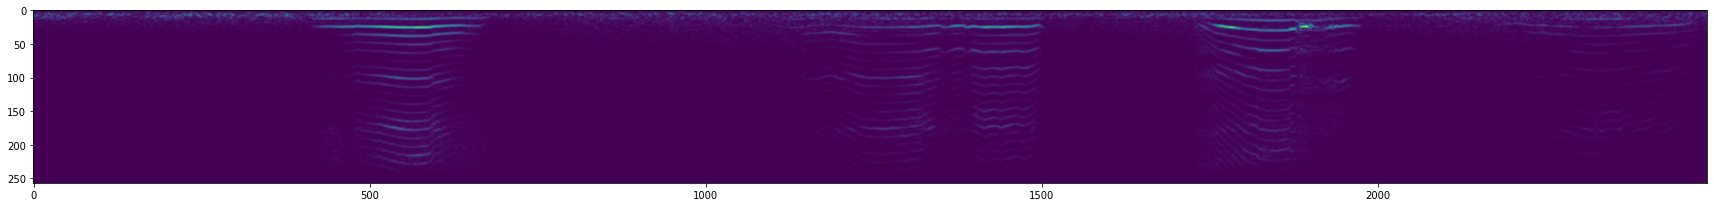

In [25]:
filepath, label = pos_data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [26]:
all_data = all_data.map(preprocess)
all_data = all_data.map(normalize)
all_data = all_data.cache()
all_data = all_data.shuffle(buffer_size=1000)
all_data = all_data.batch(16)
all_data = all_data.prefetch(8)

# Corrected cardinality function usage
num_files = tf.data.experimental.cardinality(all_data).numpy()
print(f"Total number of files in all_data: {num_files}")

Total number of files in all_data: 57


In [27]:
for spectrograms, labels in all_data.take(1):
    print(f"Spectrograms shape: {spectrograms.shape}")
    print(f"Spectrograms data type: {spectrograms.dtype}")
    print(f"Spectrograms sample data: {spectrograms.numpy()[0]}")  # 첫 번째 샘플 데이터 일부 출력
    print(f"Labels: {labels.numpy()}")

Spectrograms shape: (16, 2491, 257, 1)
Spectrograms data type: <dtype: 'float32'>
Spectrograms sample data: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
Labels: [0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.]


In [28]:
all_data = all_data.map(resize_batch_spectrograms)

In [41]:
# 데이터셋 크기 확인
dataset_size = tf.data.experimental.cardinality(all_data).numpy()
print(f"전체 데이터셋 크기: {dataset_size}")

if dataset_size == 0:
    raise ValueError("데이터셋이 비어 있습니다. 데이터를 다시 확인해주세요.")

# 데이터셋 크기가 너무 작으면 분할 비율을 조정
min_data_required = 10  # 최소한의 데이터 개수 설정 (예: 10개)
if dataset_size < min_data_required:
    print("데이터셋이 너무 작습니다. 전체 데이터셋을 학습용으로 사용합니다.")
    train_dataset = all_data
    val_dataset = tf.data.Dataset.from_tensor_slices(([], []))  # 빈 검증 데이터셋
    test_dataset = tf.data.Dataset.from_tensor_slices(([], []))  # 빈 테스트 데이터셋
else:
    # 충분한 데이터가 있을 경우 기본 비율로 분할
    train_size = int(0.7 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset = all_data.take(train_size)
    remaining_data = all_data.skip(train_size)
    val_dataset = remaining_data.take(val_size)
    test_dataset = remaining_data.skip(val_size)

# 각 데이터셋 크기 출력
print(f"전체 데이터셋 크기: {dataset_size}")
print(f"학습 데이터셋 크기: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"검증 데이터셋 크기: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"테스트 데이터셋 크기: {tf.data.experimental.cardinality(test_dataset).numpy()}")

# Convert datasets to NumPy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset.as_numpy_iterator():
        images.append(batch_images)
        labels.append(batch_labels)
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

# 데이터셋을 NumPy 배열로 변환
x_train, y_train = dataset_to_numpy(train_dataset)
x_val, y_val = dataset_to_numpy(val_dataset)
x_test, y_test = dataset_to_numpy(test_dataset)

# 데이터셋 크기 확인
print(f"Train dataset size: {x_train.shape}, {y_train.shape}")
print(f"Validation dataset size: {x_val.shape}, {y_val.shape}")
print(f"Test dataset size: {x_test.shape}, {y_test.shape}")

전체 데이터셋 크기: 57
전체 데이터셋 크기: 57
학습 데이터셋 크기: 39
검증 데이터셋 크기: 11
테스트 데이터셋 크기: 7
Train dataset size: (624, 500, 161, 1), (624,)
Validation dataset size: (176, 500, 161, 1), (176,)
Test dataset size: (98, 500, 161, 1), (98,)


In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# model structure : Big-convolutional Layer + residual_block + Transformer_encoder

def residual_block(x, filters, kernel_size=(3, 1), stride=1):
    # First convolution layer
    res = Conv2D(filters, kernel_size, strides=stride, padding="same", activation='elu',
                 kernel_regularizer=l2(0.01))(x)
    res = BatchNormalization()(res)

    res = Conv2D(filters, kernel_size, strides=stride, padding="same",
                 kernel_regularizer=l2(0.01))(res)
    res = BatchNormalization()(res)

    x = Add()([x, res])
    x = tf.nn.elu(x)
    return x

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part with Residual Block
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, res])
    return x


# Main model with reduced Dropout and Transformer blocks
def create_time_model(input_shape, k_size, rate=0.3):
    inputs = Input(shape=input_shape)

    # Big Convolutional Layer with Dropout
    x = Conv2D(k_size, kernel_size=(9, 161), activation='elu', strides=1,
               kernel_regularizer=l2(0.01))(inputs)
    x = Dropout(0.3)(x)  # Dropout rate reduced from 0.5 to 0.3
    x = BatchNormalization()(x)

    # Residual Block
    x = residual_block(x, k_size)
    a_size = x.shape[1]

    # Reshape for Transformer input
    x = Reshape((a_size, -1))(x)

    # Transformer Encoder Blocks (reduced to 2 blocks)
    num_heads = 4
    head_size = 64
    ff_dim = 256  # Reduced from 512 to 256
    num_transformer_blocks = 2

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, rate)

    # Pooling and Dense Layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=inputs, outputs=x)

# 예시로 모델 생성
input_shape = (500, 161, 1)
model = create_time_model(input_shape, k_size=64)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500, 161, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 492, 1, 64)   92800       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 492, 1, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 492, 1, 64)   256         dropout_20[0][0]                 
____________________________________________________________________________________________

In [45]:
# Learning Rate Scheduler for gradually reducing learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Model training with callbacks
hist = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), batch_size=64,
                 callbacks=[reduce_lr, early_stopping, model_checkpoint])

Epoch 1/1000
10/10 [==============================] - 30s 3s/step - loss: 4.7609 - accuracy: 0.8285 - val_loss: 4.5496 - val_accuracy: 0.8920
Epoch 2/1000
10/10 [==============================] - 27s 3s/step - loss: 4.3096 - accuracy: 0.9407 - val_loss: 4.0828 - val_accuracy: 0.9432
Epoch 3/1000
10/10 [==============================] - 27s 3s/step - loss: 3.9050 - accuracy: 0.9519 - val_loss: 3.7311 - val_accuracy: 0.9545
Epoch 4/1000
10/10 [==============================] - 27s 3s/step - loss: 3.5987 - accuracy: 0.9503 - val_loss: 3.4440 - val_accuracy: 0.9489
Epoch 5/1000
10/10 [==============================] - 27s 3s/step - loss: 3.2852 - accuracy: 0.9599 - val_loss: 3.2088 - val_accuracy: 0.9432
Epoch 6/1000
10/10 [==============================] - 28s 3s/step - loss: 3.0235 - accuracy: 0.9567 - val_loss: 2.9947 - val_accuracy: 0.9318
Epoch 7/1000
10/10 [==============================] - 28s 3s/step - loss: 2.7741 - accuracy: 0.9455 - val_loss: 2.8027 - val_accuracy: 0.8977
Epoch 

In [46]:
from tensorflow.keras.models import load_model

# 저장된 best 모델 불러오기
best_model = load_model('best_model.h5')

test_loss, test_accuracy= best_model.evaluate(x_test,y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 2s 313ms/step - loss: 0.0588 - accuracy: 1.0000
Test Loss: 0.058838069438934326
Test Accuracy: 1.0
